In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hadamard as hd
from scipy.stats import bernoulli as bn

In [2]:
def get_array(d):
#     while True:
    arr = np.random.randn(d,)
#         norm= np.linalg.norm(arr)
#         if norm <= 1:
    return list(arr/3)

In [3]:
def get_x(n,d):
    x=[]
    for _ in range(n):
        z=get_array(d)
        x.append(z)
    return x
#x_mean list represents average of x in each client


In [4]:
def R(d):
    fixed_diagonal_elements=np.ones(d//2)
    r=bn.rvs(0.5,size=(d//2))
    changing_diagonal_elements=2*r-1
    diagonal_elements=np.concatenate((fixed_diagonal_elements,changing_diagonal_elements),axis=None)
    D=np.diag(np.array(diagonal_elements))
    print(D)
    H=hd(d)
    R=np.matmul(H,D)
    return R

In [5]:
n=16
d=512
iters=20
x1 = get_x(n,d)
x=np.transpose(x1)
R=R(d)
#print(R)
z1=np.matmul(R,x)
z=np.transpose(z1)
R_inv=np.linalg.inv(R)
x_mean=np.mean(x1,axis=0)
# print(np.mean(x1,axis=0))
# print(x_mean)

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]


In [6]:
def encoder(x,n,d,k):
    B=[]
    v=[]
    for i in range(n):
        u=x[i]
        x_min=np.min(u)
        x_max=np.max(u)
        s=x_max-x_min
        B_=np.linspace(x_min,x_max,num=k)
        v_=np.searchsorted(B_,u,side='right')-1   
        v.append(v_.tolist())
        B_client=np.append(B_,0)
        B.append(B_client.tolist())
        
    return B,v

In [7]:
def decoder(B,v,x,d):
    Y=[]
    sum1=0
    for i in range(n):
        u=x[i]
        x_max=np.max(u)
        x_min=np.min(u)
        y=[]
        for j in range(d):
            #B[j]=B(r)
            y_est=0
            r=v[i][j]
            q=B[i][r]
            w=B[i][r+1]
            p=(u[j]-q)/(w-q)     
            l=(3*w+q)/4
            m=(3*q+w)/4
            y_est=random.choices([l,m],[p,1-p])[0]
            y.append(y_est)   
        Y.append(y)
    return Y

In [8]:
def loss_k(k1):
    loss=0

    k=2**k1
    for _ in range(iters):
        
        B,v=encoder(x1,n,d,k)
        #print(B,v)
        Y=decoder(B,v,x1,d)

        x_mean_est=np.mean(Y,axis=0)
        error=np.subtract(x_mean_est,x_mean)
        loss+=(np.linalg.norm(error))**2
    return (loss/iters)

In [9]:
def encoder_rotation(z,n,d,k):
    B=[]
    v=[]
    for i in range(n):
        u=z[i]
        z_min=np.min(u)
        z_max=np.max(u)
        s=z_max-z_min
        B_=np.linspace(z_min,z_max,num=k)
        v_=np.searchsorted(B_,u,side='right')-1   
        v.append(v_.tolist())
        B_client=np.append(B_,0)
        B.append(B_client.tolist())
    
    #print(B,"\n",v)    
    return B,v

In [10]:
def decoder_rotation(B,v,z,d):
    Y=[]
    sum1=0
    for i in range(n):
        u=z[i]
        z_max=np.max(u)
        z_min=np.min(u)
        y=[]
        for j in range(d):
            #B[j]=B(r)
            y_est=0
            r=v[i][j]
            q=B[i][r]
            w=B[i][r+1]
            p=(u[j]-q)/(w-q)
            l=(3*w+q)/4
            m=(3*q+w)/4
            y_est=random.choices([l,m],[p,1-p])[0]
            y.append(y_est)   
        Y.append(y)
    return Y

In [11]:
def loss_k_rotation(k1):
    loss=0
    k=2**k1
    for _ in range(iters):

        B,v=encoder_rotation(z,n,d,k)
        #print(B,v)
        Y=decoder_rotation(B,v,z,d)

        x_mean_est_rotated=np.mean(Y,axis=0)
        x_mean_est=np.matmul(R_inv,x_mean_est_rotated)
        
        error=np.subtract(x_mean_est,x_mean)
        
        loss+=(np.linalg.norm(error))**2
    return (loss/iters)

In [15]:
losses=[]
losses_rotation=[]
for k in range(1,8):
    #print(x)
    loss_rotation=loss_k_rotation(k)
    loss=loss_k(k)
    losses_rotation.append(loss_rotation)
    losses.append(loss)
   

In [16]:
print(losses_rotation)
print(losses)

[7.706504921829132, 0.8397038793832614, 0.15709634194649036, 0.03888127570930642, 0.011747346613763783, 0.0056989301049782054, 0.0043598429475035574]
[8.68916204386072, 0.9935840779393755, 0.17721925378104667, 0.04272402300956267, 0.013320044580652151, 0.006209897589921564, 0.004430457855385134]


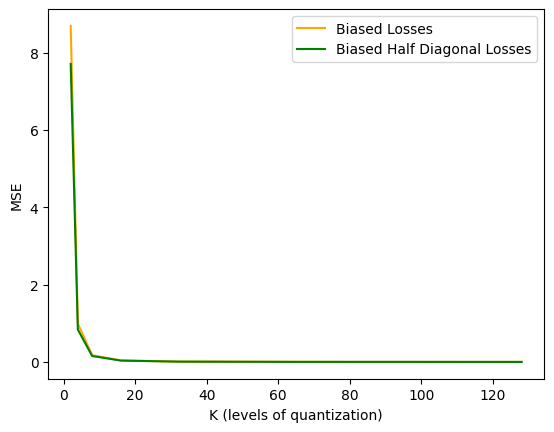

In [21]:
plt.plot(2**np.arange(1,8),(losses),color="orange",label='Biased Losses')
plt.plot(2**np.arange(1,8),(losses_rotation),color="g",label='Biased Half Diagonal Losses')
plt.xlabel("K (levels of quantization)")
plt.ylabel("MSE")
plt.legend()
plt.savefig("MSE_Biased_vs_Biased_Half_Diagonal.pdf")